In [1]:
#| default_exp models.informer

# Informer

The Informer model tackles the vanilla Transformer computational complexity challenges for long-horizon forecasting.

The architecture has three distinctive features:
- A ProbSparse self-attention mechanism with an O time and memory complexity Llog(L).
- A self-attention distilling process that prioritizes attention and efficiently handles long input sequences.
- An MLP multi-step decoder that predicts long time-series sequences in a single forward operation rather than step-by-step.

The Informer model utilizes a three-component approach to define its embedding:
- It employs encoded autoregressive features obtained from a convolution network.
- It uses window-relative positional embeddings derived from harmonic functions.
- Absolute positional embeddings obtained from calendar features are utilized.

**References**<br>
- [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>

![Figure 1. Temporal Fusion Transformer Architecture.](imgs_models/informer_architecture.png)

In [2]:
#| export
import math
import numpy as np
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.common._modules import (
    TransEncoderLayer, TransEncoder,
    TransDecoderLayer, TransDecoder,
    DataEmbedding, AttentionLayer,
)
from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary Functions

In [4]:
#| export
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x

In [5]:
#| export
class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask


class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):  # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)

        index_sample = torch.randint(L_K, (L_Q, sample_k))  # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]  # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))  # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:  # use mask
            assert (L_Q == L_V)  # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) / L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1. / math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.contiguous(), attn

## 2. Informer

In [6]:
#| export
class Informer(BaseWindows):
    """ Informer

	The Informer model tackles the vanilla Transformer computational complexity challenges for long-horizon forecasting. 
	The architecture has three distinctive features:
        1) A ProbSparse self-attention mechanism with an O time and memory complexity Llog(L).
        2) A self-attention distilling process that prioritizes attention and efficiently handles long input sequences.
        3) An MLP multi-step decoder that predicts long time-series sequences in a single forward operation rather than step-by-step.

    The Informer model utilizes a three-component approach to define its embedding:
        1) It employs encoded autoregressive features obtained from a convolution network.
        2) It uses window-relative positional embeddings derived from harmonic functions.
        3) Absolute positional embeddings obtained from calendar features are utilized.

    *Parameters:*<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
	`decoder_input_size_multiplier`: float = 0.5, .<br>
    `hidden_size`: int=128, units of embeddings and encoders.<br>
    `n_head`: int=4, controls number of multi-head's attention.<br>
    `dropout`: float (0, 1), dropout throughout Informer architecture.<br>
	`factor`: int=3, Probsparse attention factor.<br>
	`conv_hidden_size`: int=32, channels of the convolutional encoder.<br>
	`activation`: str=`GELU`, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'GELU'].<br>
    `encoder_layers`: int=2, number of layers for the TCN encoder.<br>
    `decoder_layers`: int=1, number of layers for the MLP decoder.<br>
    `distil`: bool = True, wether the Informer decoder uses bottlenecks.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

	*References*<br>
	- [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>
    """
    def __init__(self,
                 h: int, 
                 input_size: int,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 decoder_input_size_multiplier: float = 0.5,
                 hidden_size: int = 128, 
                 dropout: float = 0.05,
                 factor: int = 3,
                 n_head: int = 4,
                 conv_hidden_size: int = 32,
                 activation: str = 'gelu',
                 encoder_layers: int = 2, 
                 decoder_layers: int = 1, 
                 distil: bool = True,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):
        super(Informer, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        if self.stat_input_size > 0:
            raise Exception('Informer does not support static variables yet')
        
        if self.hist_input_size > 0:
            raise Exception('Informer does not support historical variables yet')

        self.label_len = int(np.ceil(input_size * decoder_input_size_multiplier))
        if (self.label_len >= input_size) or (self.label_len <= 0):
            raise Exception(f'Check decoder_input_size_multiplier={decoder_input_size_multiplier}, range (0,1)')

        if activation not in ['relu', 'gelu']:
            raise Exception(f'Check activation={activation}')
        
        self.c_out = self.loss.outputsize_multiplier
        self.output_attention = False
        self.enc_in = 1 
        self.dec_in = 1

        # Embedding
        self.enc_embedding = DataEmbedding(c_in=self.enc_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=True,
                                           dropout=dropout)
        self.dec_embedding = DataEmbedding(self.dec_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=True,
                                           dropout=dropout)

        # Encoder
        self.encoder = TransEncoder(
            [
                TransEncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor,
                                      attention_dropout=dropout,
                                      output_attention=self.output_attention),
                        hidden_size, n_head),
                    hidden_size,
                    conv_hidden_size,
                    dropout=dropout,
                    activation=activation
                ) for l in range(encoder_layers)
            ],
            [
                ConvLayer(
                    hidden_size
                ) for l in range(encoder_layers - 1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(hidden_size)
        )
        # Decoder
        self.decoder = TransDecoder(
            [
                TransDecoderLayer(
                    AttentionLayer(
                        ProbAttention(True, factor, attention_dropout=dropout, output_attention=False),
                        hidden_size, n_head),
                    AttentionLayer(
                        ProbAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        hidden_size, n_head),
                    hidden_size,
                    conv_hidden_size,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(decoder_layers)
            ],
            norm_layer=torch.nn.LayerNorm(hidden_size),
            projection=nn.Linear(hidden_size, self.c_out, bias=True)
        )

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']

        futr_exog     = windows_batch['futr_exog']

        insample_y = insample_y.unsqueeze(-1) # [Ws,L,1]

        if self.futr_input_size > 0:
            x_mark_enc = futr_exog[:,:self.input_size,:]
            x_mark_dec = futr_exog[:,-(self.label_len+self.h):,:]
        else:
            x_mark_enc = None
            x_mark_dec = None

        x_dec = torch.zeros(size=(len(insample_y),self.h,1))
        x_dec = torch.cat([insample_y[:,-self.label_len:,:], x_dec], dim=1)        

        enc_out = self.enc_embedding(insample_y, x_mark_enc)
        enc_out, _ = self.encoder(enc_out, attn_mask=None) # attns visualization

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, 
                               cross_mask=None)

        forecast = self.loss.domain_map(dec_out[:, -self.h:])
        return forecast

In [7]:
show_doc(Informer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/informer.py#L172){target="_blank" style="float:right; font-size:smaller"}

### Informer

>      Informer (h:int, input_size:int, stat_exog_list=None,
>                hist_exog_list=None, futr_exog_list=None,
>                decoder_input_size_multiplier:float=0.5, hidden_size:int=128,
>                dropout:float=0.05, factor:int=3, n_head:int=4,
>                conv_hidden_size:int=32, activation:str='gelu',
>                encoder_layers:int=2, decoder_layers:int=1, distil:bool=True,
>                loss=MAE(), valid_loss=None, max_steps:int=5000,
>                learning_rate:float=0.0001, num_lr_decays:int=-1,
>                early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                batch_size:int=32, valid_batch_size:Optional[int]=None,
>                windows_batch_size=1024, step_size:int=1,
>                scaler_type:str='identity', random_seed:int=1,
>                num_workers_loader:int=0, drop_last_loader:bool=False,
>                **trainer_kwargs)

Informer

    The Informer model tackles the vanilla Transformer computational complexity challenges for long-horizon forecasting. 
    The architecture has three distinctive features:
    1) A ProbSparse self-attention mechanism with an O time and memory complexity Llog(L).
    2) A self-attention distilling process that prioritizes attention and efficiently handles long input sequences.
    3) An MLP multi-step decoder that predicts long time-series sequences in a single forward operation rather than step-by-step.

The Informer model utilizes a three-component approach to define its embedding:
    1) It employs encoded autoregressive features obtained from a convolution network.
    2) It uses window-relative positional embeddings derived from harmonic functions.
    3) Absolute positional embeddings obtained from calendar features are utilized.

*Parameters:*<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
    `decoder_input_size_multiplier`: float = 0.5, .<br>
`hidden_size`: int=128, units of embeddings and encoders.<br>
`n_head`: int=4, controls number of multi-head's attention.<br>
`dropout`: float (0, 1), dropout throughout Informer architecture.<br>
    `factor`: int=3, .<br>
    `conv_hidden_size`: int=32, channels of the convolutional encoder.<br>
    `activation`: str=`GELU`, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'GELU'].<br>
`encoder_layers`: int=2, number of layers for the TCN encoder.<br>
`decoder_layers`: int=1, number of layers for the MLP decoder.<br>
`distil`: bool = True, wether the Informer decoder uses bottlenecks.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    *References*<br>
    - [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>

In [8]:
show_doc(Informer.fit, name='Informer.fit')

---

### Informer.fit

>      Informer.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [9]:
show_doc(Informer.predict, name='Informer.predict')

---

### Informer.predict

>      Informer.predict (dataset, test_size=None, step_size=1,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.72it/s]


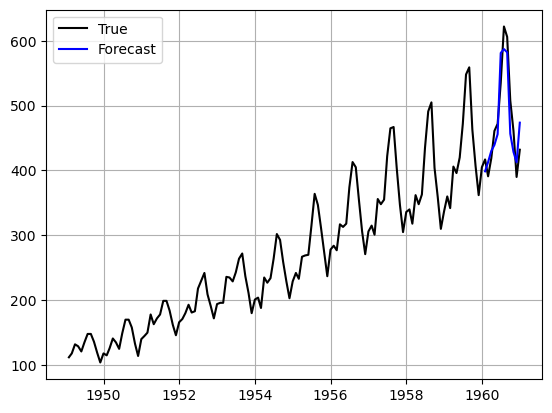

In [10]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = Informer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head = 2,
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Informer-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['Informer-lo-90'][-12:].values, 
                    y2=plot_df['Informer-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Informer'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()